In [1]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.0 MB/s eta 0:00:00


In [2]:
import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import copy

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/libpyg.so: undefined symbol: _ZN3c1010Dispatcher17runRecordFunctionERN2at14RecordFunctionESt17reference_wrapperIKNS_14FunctionSchemaEENS_11DispatchKeyE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_clu

In [3]:
import pandas as pd
data = pd.read_csv("omnipath.csv")

data = data.iloc[:, [1, 2, 3]]

from sklearn.preprocessing import LabelEncoder

node_encoder = LabelEncoder()

nodes = pd.concat([data['from'], data['to']]).unique()
node_encoder.fit(nodes)

data['from_encoded'] = node_encoder.transform(data['from'])
data['to_encoded'] = node_encoder.transform(data['to'])

**Graph Attention Autoencoders**

In [21]:
from torch_geometric.nn import GATConv
from torch_geometric.nn import GAE

class GATEEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels, heads=8):
        super(GATEEncoder, self).__init__()
        self.conv1 = GATConv(in_channels, 2 * out_channels, heads=heads, concat=True)  #  If set to False, the multi-head attentions are averaged instead of concatenated
        self.conv2 = GATConv(2 * out_channels * heads, out_channels, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

In [22]:
model.encode(x, train_pos_edge_index)

tensor([[-24.1691,  -8.1421,  15.4866,  ...,  21.0885, -15.5481, -14.7741],
        [-29.3265,  -9.8971,  18.8415,  ...,  25.6286, -19.0986, -18.0011],
        [-26.8034,  -9.0622,  17.2289,  ...,  23.4659, -17.3831, -16.4482],
        ...,
        [-26.5256,  -8.9604,  17.0425,  ...,  23.2299, -17.2121, -16.2728],
        [-27.0086,  -9.1245,  17.3618,  ...,  23.6445, -17.5193, -16.5740],
        [-26.0996,  -8.7853,  16.7746,  ...,  22.8457, -16.9311, -16.0367]],
       grad_fn=<AddBackward0>)

In [17]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)

    loss.backward()
    optimizer.step()

    loss2 = model.recon_loss(z, val_pos_edge_index)
    return float(loss), float(loss2)

def val(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

def test(model_best,pos_edge_index, neg_edge_index):
    model_best.eval()
    with torch.no_grad():
        z = model_best.encode(x, train_pos_edge_index)
        pos_prob = model_best.decode(z, pos_edge_index)
        neg_prob = model_best.decode(z, neg_edge_index)

    return pos_prob, neg_prob

In [23]:
edge_index = torch.tensor([data['from_encoded'].values, data['to_encoded'].values], dtype=torch.long)
edge_attr = torch.tensor(data['sign'].values, dtype=torch.float).unsqueeze(1)  # Edge Shape: (num_edges, 1)

num_nodes = max(data['from_encoded'].max(), data['to_encoded'].max()) + 1  # Unique nodes
node_features = torch.rand((num_nodes, 64), dtype=torch.float)  # Node feature Shape: (num_nodes, 64)

# PyG Data object
data_py = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

data_py = train_test_split_edges(data_py)

# parameters
out_channels = 31
num_features = data_py.x.shape[1]
epochs = 300

# model
model = GAE(GATEEncoder(num_features, out_channels))


# move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data_py.x.to(device)
train_pos_edge_index = data_py.train_pos_edge_index.to(device)
val_pos_edge_index = data_py.val_pos_edge_index.to(device)
#edge_attr = data_py.train_pos_edge_attr.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0076774009767145044)


best_val_auc = 0
best_model = None

a = []
b = []
c = []
d = []

for epoch in range(300):
    loss, loss2 = train()
    a.append(loss)
    d.append(loss2)

    # Evaluate on validation set
    val_auc, val_ap = val(data_py.val_pos_edge_index, data_py.val_neg_edge_index)
    print('Epoch: {:03d}, Loss: {:.4f}, Val AUC: {:.4f}, Val AP: {:.4f}'.format(epoch, loss, val_auc, val_ap))
    b.append(val_auc)
    c.append(val_ap)

    # Saving the best model based on validation performance and to prevent overfitting
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = copy.deepcopy(model)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 000, Loss: 2.4370, Val AUC: 0.5395, Val AP: 0.5206
Epoch: 001, Loss: 33.0142, Val AUC: 0.5855, Val AP: 0.5470
Epoch: 002, Loss: 30.8335, Val AUC: 0.4440, Val AP: 0.4240
Epoch: 003, Loss: 6.8616, Val AUC: 0.4865, Val AP: 0.4425
Epoch: 004, Loss: 1.7499, Val AUC: 0.4420, Val AP: 0.4223
Epoch: 005, Loss: 1.3942, Val AUC: 0.5188, Val AP: 0.4585
Epoch: 006, Loss: 1.3936, Val AUC: 0.4887, Val AP: 0.4446
Epoch: 007, Loss: 1.4133, Val AUC: 0.4826, Val AP: 0.4414
Epoch: 008, Loss: 1.4236, Val AUC: 0.4529, Val AP: 0.4278
Epoch: 009, Loss: 1.4244, Val AUC: 0.4525, Val AP: 0.4274
Epoch: 010, Loss: 1.4205, Val AUC: 0.4711, Val AP: 0.4357
Epoch: 011, Loss: 1.4133, Val AUC: 0.4971, Val AP: 0.4476
Epoch: 012, Loss: 1.4038, Val AUC: 0.4813, Val AP: 0.4393
Epoch: 013, Loss: 1.3964, Val AUC: 0.4812, Val AP: 0.4396
Epoch: 014, Loss: 1.3922, Val AUC: 0.5069, Val AP: 0.4524
Epoch: 015, Loss: 1.3905, Val AUC: 0.5194, Val AP: 0.4583
Epoch: 016, Loss: 1.3889, Val AUC: 0.5265, Val AP: 0.4619
Epoch: 017, 

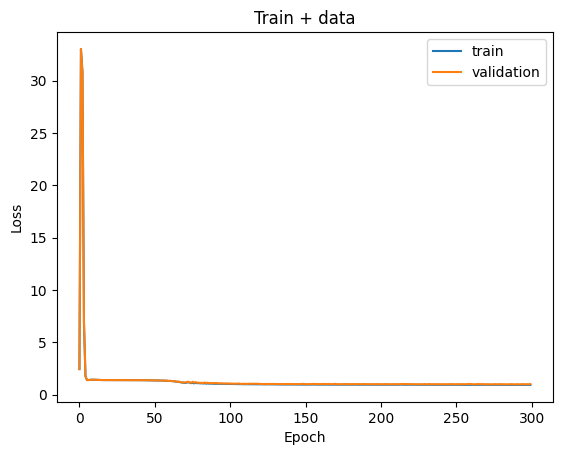

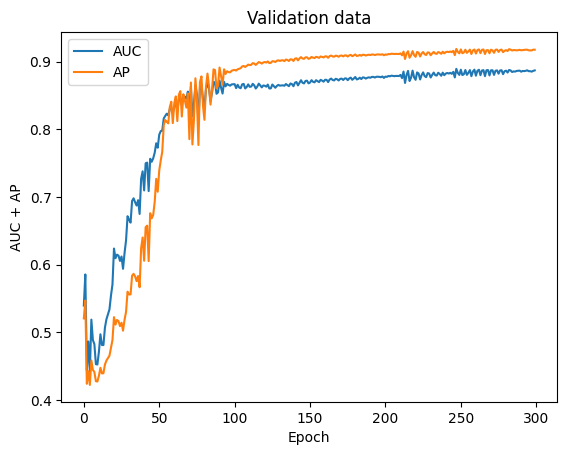

In [24]:
plt.plot(a)
plt.plot(d)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train","validation"])
plt.title("Train + data")
plt.show()

plt.plot(b)
plt.plot(c)
plt.xlabel("Epoch")
plt.ylabel("AUC + AP")
plt.title("Validation data")
plt.legend(["AUC","AP"])
plt.show()

In [25]:
model_1 = best_model
pos_1, neg_1 = test(model_1,data_py.test_pos_edge_index, data_py.test_neg_edge_index)

In [33]:
percentage = ((pos_1 >= 0.7).sum() / 4366) * 100
print(f"{percentage.item():.2f}% links predicted correctly")

77.35% links predicted correctly


** Varitional Graph Attention Autoencoders**

In [36]:
from torch_geometric.nn import VGAE


class GATEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels, heads=8):
        super(GATEncoder, self).__init__()
        self.conv1 = GATConv(in_channels, 2* out_channels, heads=heads, concat=True)
        self.conv_mu = GATConv(2* out_channels * heads, out_channels, heads=1, concat=False)
        self.conv_logstd = GATConv(2* out_channels * heads, out_channels, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [37]:
def train_2():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)

    loss = loss + (1 / data_py.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    loss2 = model.recon_loss(z, val_pos_edge_index)
    return float(loss), float(loss2)

In [ ]:
edge_index = torch.tensor([data['from_encoded'].values, data['to_encoded'].values], dtype=torch.long)
edge_attr = torch.tensor(data['sign'].values, dtype=torch.float).unsqueeze(1)  # Edge Shape: (num_edges, 1)

num_nodes = max(data['from_encoded'].max(), data['to_encoded'].max()) + 1  # Unique nodes
node_features = torch.rand((num_nodes, 32), dtype=torch.float)  # Node feature Shape: (num_nodes, 32)

# PyG Data object
data_py = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

data_py = train_test_split_edges(data_py)

# parameters
out_channels = 42
num_features = data_py.x.shape[1]
epochs = 300

# model
model = VGAE(GATEncoder(num_features, out_channels))


# move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data_py.x.to(device)
train_pos_edge_index = data_py.train_pos_edge_index.to(device)
val_pos_edge_index = data_py.val_pos_edge_index.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.009936477241185999)


best_val_auc = 0
best_model = None

a = []
b = []
c = []
d = []

for epoch in range(300):
    loss, loss2 = train_2()
    a.append(loss)
    d.append(loss2)

    # Evaluate on validation set
    val_auc, val_ap = val(data_py.val_pos_edge_index, data_py.val_neg_edge_index)
    print('Epoch: {:03d}, Loss: {:.4f}, Val AUC: {:.4f}, Val AP: {:.4f}'.format(epoch, loss, val_auc, val_ap))
    b.append(val_auc)
    c.append(val_ap)

    # Saving the best model based on validation performance and to prevent overfitting
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = copy.deepcopy(model)

Epoch: 000, Loss: 6.4712, Val AUC: 0.3733, Val AP: 0.3980
Epoch: 001, Loss: 11.1009, Val AUC: 0.6780, Val AP: 0.5693
Epoch: 002, Loss: 1.9051, Val AUC: 0.5356, Val AP: 0.4686
Epoch: 003, Loss: 4.5303, Val AUC: 0.5026, Val AP: 0.4512
Epoch: 004, Loss: 2.9856, Val AUC: 0.5699, Val AP: 0.4887
Epoch: 005, Loss: 2.0257, Val AUC: 0.5416, Val AP: 0.4736
Epoch: 006, Loss: 1.8815, Val AUC: 0.5047, Val AP: 0.4543
Epoch: 007, Loss: 2.0447, Val AUC: 0.4716, Val AP: 0.4381
Epoch: 008, Loss: 1.8461, Val AUC: 0.4257, Val AP: 0.4176
Epoch: 009, Loss: 1.6890, Val AUC: 0.4646, Val AP: 0.4347
Epoch: 010, Loss: 1.5997, Val AUC: 0.4872, Val AP: 0.4454
Epoch: 011, Loss: 1.5219, Val AUC: 0.4995, Val AP: 0.4519
Epoch: 012, Loss: 1.4637, Val AUC: 0.4826, Val AP: 0.4434
Epoch: 013, Loss: 1.4280, Val AUC: 0.4832, Val AP: 0.4438
Epoch: 014, Loss: 1.4236, Val AUC: 0.4895, Val AP: 0.4466
Epoch: 015, Loss: 1.4084, Val AUC: 0.4940, Val AP: 0.4483
Epoch: 016, Loss: 1.4086, Val AUC: 0.4974, Val AP: 0.4500
Epoch: 017, L

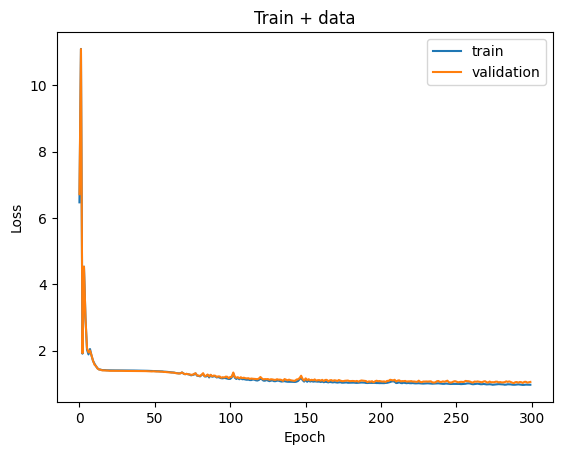

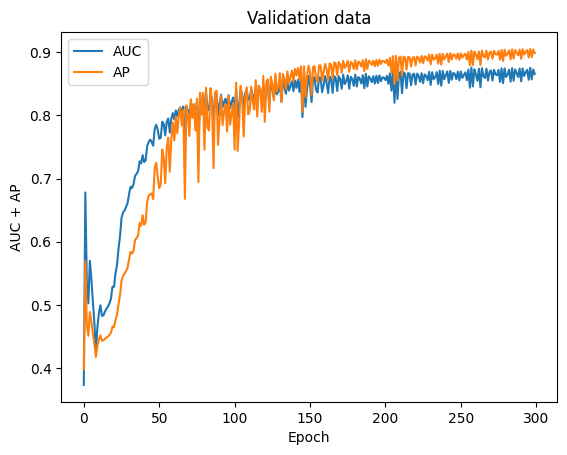

In [ ]:
plt.plot(a)
plt.plot(d)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train","validation"])
plt.title("Train + data")
plt.show()

plt.plot(b)
plt.plot(c)
plt.xlabel("Epoch")
plt.ylabel("AUC + AP")
plt.title("Validation data")
plt.legend(["AUC","AP"])
plt.show()

In [ ]:
model_2 = best_model
pos_2, neg_2 = test(model_2,data_py.test_pos_edge_index, data_py.test_neg_edge_index)

In [ ]:
percentage = ((pos_2 >= 0.7).sum() / 4366) * 100
print(f"{percentage.item():.2f}% links predicted correctly")

78.49% links predicted correctly


Now we shall add further tune this architecture by experimenting with dropout, batch normalization etc.

In [38]:
def train_3():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    recon_loss = model.recon_loss(z, train_pos_edge_index)

    kl_loss = (1 / data_py.num_nodes) * model.kl_loss()


    # L2 regularization
    l2_lambda = 1e-5
    l2_reg = sum(torch.sum(param ** 2) for param in model.parameters())

    # Total loss
    loss = recon_loss + kl_loss + l2_lambda * l2_reg

    loss.backward()
    optimizer.step()
    loss2 = model.recon_loss(z, val_pos_edge_index)
    return float(loss), float(loss2)

In [ ]:
class VariationalGATEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels, heads=8):
        super(VariationalGATEncoder, self).__init__()


        self.conv1 = GATConv(in_channels, 2 * out_channels, heads=heads, concat=True)
        self.bn1 = torch.nn.BatchNorm1d(2 * out_channels * heads)

        self.conv2 = GATConv(2 * out_channels * heads, 2 * out_channels, heads=heads, concat=True)
        self.bn2 = torch.nn.BatchNorm1d(2 * out_channels * heads)

        self.conv_mu = GATConv(2 * out_channels * heads, out_channels, heads=1, concat=False)
        self.conv_logstd = GATConv(2 * out_channels * heads, out_channels, heads=1, concat=False)

        self.dropout = torch.nn.Dropout(p=0.5)


        self.act = torch.nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = self.act(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = self.act(x)
        x = self.dropout(x)

        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

edge_index = torch.tensor([data['from_encoded'].values, data['to_encoded'].values], dtype=torch.long)
edge_attr = torch.tensor(data['sign'].values, dtype=torch.float).unsqueeze(1)  # Edge Shape: (num_edges, 1)

num_nodes = max(data['from_encoded'].max(), data['to_encoded'].max()) + 1  # Unique nodes
node_features = torch.rand((num_nodes, 32), dtype=torch.float)  # Node feature Shape: (num_nodes, 32)

# PyG Data object
data_py = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

data_py = train_test_split_edges(data_py)

out_channels = 42
num_features = data_py.x.shape[1]
epochs = 300

# model
model = VGAE(VariationalGATEncoder(num_features, out_channels))


# move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data_py.x.to(device)
train_pos_edge_index = data_py.train_pos_edge_index.to(device)
val_pos_edge_index = data_py.val_pos_edge_index.to(device)


# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.009936477241185999)


best_val_auc = 0
best_model = None

a = []
b = []
c = []
d = []

for epoch in range(300):
    loss, loss2 = train_2()
    a.append(loss)
    d.append(loss2)

    # Evaluate on validation set
    val_auc, val_ap = val(data_py.val_pos_edge_index, data_py.val_neg_edge_index)
    print('Epoch: {:03d}, Loss: {:.4f}, Val AUC: {:.4f}, Val AP: {:.4f}'.format(epoch, loss, val_auc, val_ap))
    b.append(val_auc)
    c.append(val_ap)

    # Saving the best model based on validation performance and to prevent overfitting
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = copy.deepcopy(model)

In [ ]:
model_3 = best_model
pos_3, neg_3 = test(model_3,data_py.test_pos_edge_index, data_py.test_neg_edge_index)

In [ ]:
percentage = ((pos_3 >= 0.7).sum() / 4366) * 100
print(f"{percentage.item():.2f}% links predicted correctly")

79.39% links predicted correctly


In [ ]:
(neg_2 >= 0.99).sum()

tensor(6, device='cuda:0')